In [2]:
from qiskit import QuantumRegister,ClassicalRegister,QuantumCircuit,Aer,execute
import numpy as np
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector

In [3]:
#recursive CCC..CC Z^a
#control registers Cr must be an array or list
#target register is Tr
def recCZa(qc,a,Cr,Tr):
    if len(Cr)<=1:
        if len(Cr)==1:          #if only 1 control bit, apply the C-gate
            qc.cu1(np.pi*a,Cr[0],Tr)
        else:                   #if no control bits, just apply the gate
            qc.u1(np.pi*a,Tr)
    else:
        nn=len(Cr)
        #apply C-sqrt(U)
        recCZa(qc,a/2,[Cr[nn-1]],Tr)
       
        #recursively apply CCNot
        qc.h(Cr[nn-1])
        recCZa(qc,1,Cr[0:nn-1],Cr[nn-1])
        qc.h(Cr[nn-1])
        
        #apply C-sqrt(U dg)
        recCZa(qc,-a/2,[Cr[nn-1]],Tr)
        
        #recursively apply CCNot
        qc.h(Cr[nn-1])
        recCZa(qc,1,Cr[0:nn-1],Cr[nn-1])
        qc.h(Cr[nn-1])
        
        #recursivle apply CC-sqrt(U)
        recCZa(qc,a/2,Cr[0:nn-1],Tr)

In [4]:
def recTof(qc,Cr,Tr):
    qc.h(Tr)
    recCZa(qc,1,Cr,Tr)
    qc.h(Tr)

In [5]:
def W(qc, Cr, n):
    for i in range(1, n + 1):
        qc.h(i)
        qc.x(i)
    recCZa(qc, 1, Cr, 1)
    for j in range(1, n + 1):
        qc.x(j)
        qc.h(j)

In [6]:
def U(qc, Cr, Tr):
    qc.x(Tr)
    recTof(qc, Cr, 0)
    qc.x(Tr)

In [16]:
def Grovers(n):
    N = 2 ** n
    R = int(np.floor(np.pi * np.sqrt(N)/4))

    q = QuantumRegister(n + 1)	# Create a quantum register with n+1 qubits.
    c = ClassicalRegister(n)	# Create a classical register with n bits.
    qc = QuantumCircuit(q, c)	# Create a quantum circuit, combining q and c.

    qc.x(0)
    qc.h(0)
    
    for i in range(1, n + 1):
        qc.h(i)

    for i in range(R):
        controls = list(range(1, n + 1))
        U(qc, controls, n)
        controls = list(range(2, n + 1))
        W(qc, controls, n)

    qc.h(0)
    qc.x(0)

    for i in range(1, n + 1):
        qc.measure(i, i - 1)
    
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    
    max = -1
    for key in counts:
        if counts[key] > max:
            max = counts[key]
            maxKey = key
    print(maxKey +" is the probable a")
    return counts
#     plot_histogram(counts)

011 is the probable a


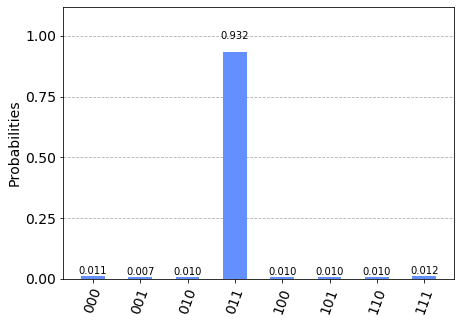

In [21]:
counts = Grovers(3)

plot_histogram(counts)

Analysis and Commentary:
The correct value of a is usually returned with a probability of > .95. Though the program crashes after inputting more than 5 input bits, it is interesting that the right answer is very clear. Our solution appears to be correct because each iteration of n = n + 1 until n = 5 returns one 0 followed by n - 1 1's, which is what we would expect as a solution from the provided oracle.